Data set taken from here: https://www.kaggle.com/moltean/fruits

# Preperations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

Set up the GPUs if we can use them.

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    print("Configuring", device)
    tf.config.experimental.set_memory_growth(device, True)

Configuring PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Import our training and test images

In [3]:
# IMAGE_SIZE = (100, 100)

# train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=25,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     brightness_range=(0.9, 1.1),
#     horizontal_flip=True,
#     vertical_flip=True,
# )

# training_images = train_image_generator.flow_from_directory(
#     directory="fruits-360/Training",
#     batch_size=32,
#     shuffle=True,
#     target_size=IMAGE_SIZE
# )

# test_images = train_image_generator.flow_from_directory(
#     directory="fruits-360/Test",
#     batch_size=32,
#     shuffle=True,
#     target_size=IMAGE_SIZE
# )

IMAGE_SIZE = (224, 224)

train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
)

training_images = train_image_generator.flow_from_directory(
    directory="natural_images",
    batch_size=32,
    shuffle=True,
    target_size=IMAGE_SIZE,
    subset="training"
)

test_images = train_image_generator.flow_from_directory(
    directory="natural_images",
    batch_size=32,
    shuffle=True,
    target_size=IMAGE_SIZE,
    subset="validation"
)

NUM_CLASSES = training_images.num_classes

Found 5522 images belonging to 8 classes.
Found 1377 images belonging to 8 classes.


Show some images from the loaded data set

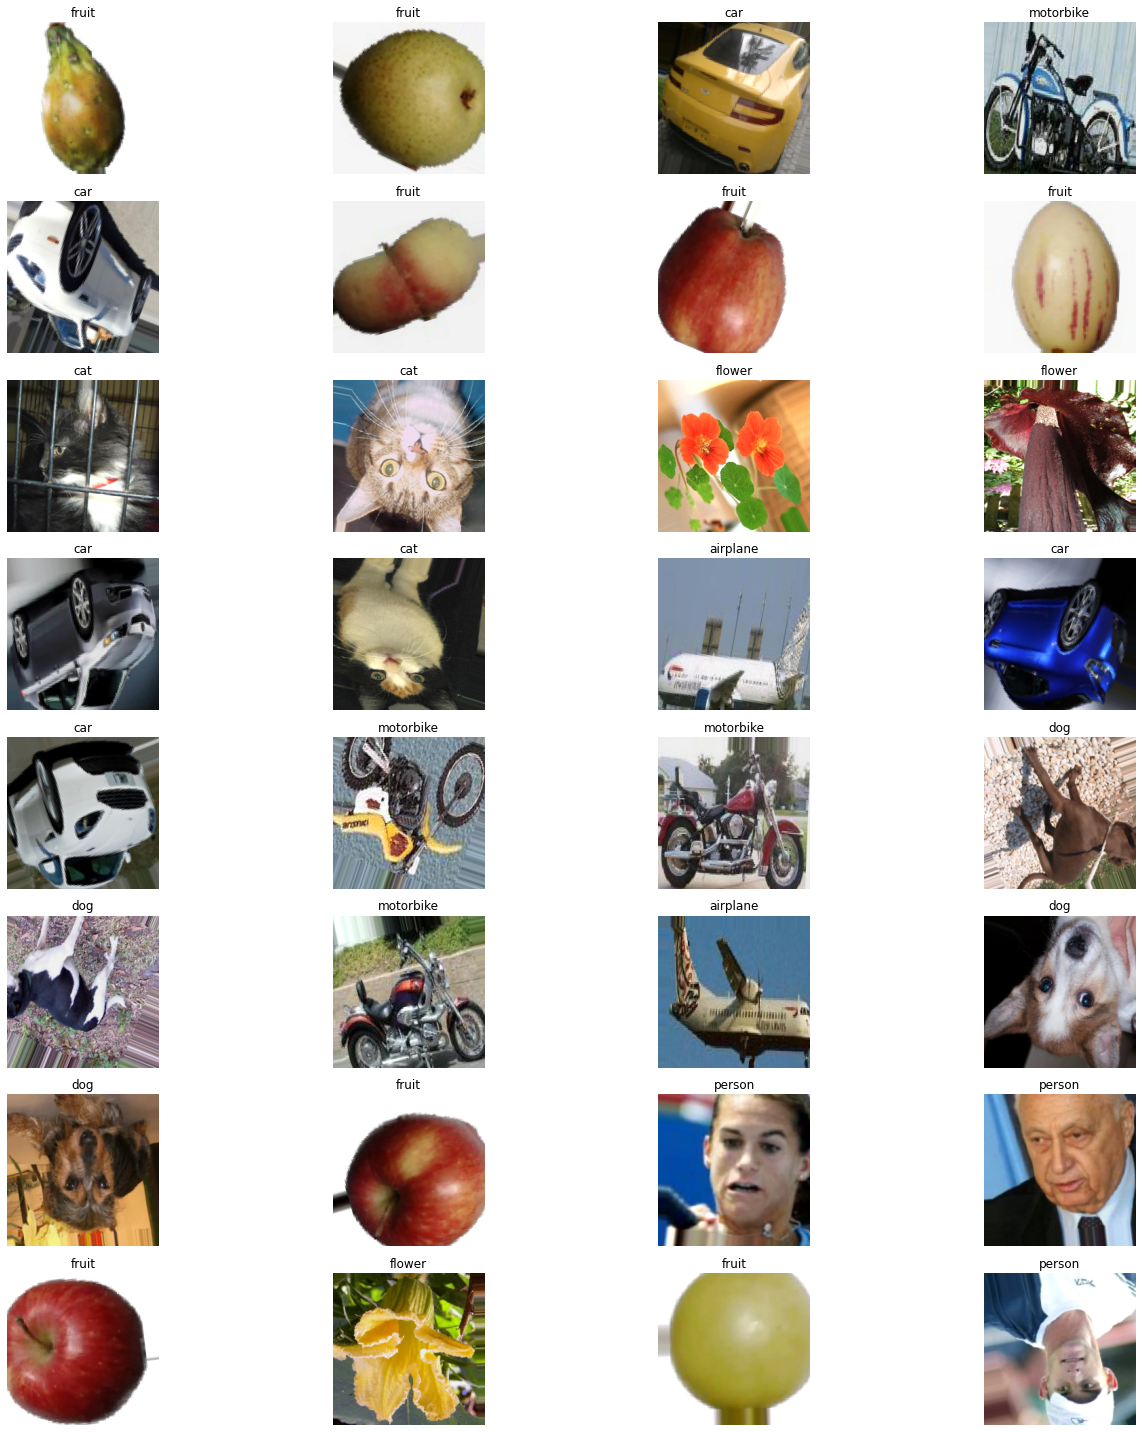

In [4]:
# plt.figure(figsize=(10, 10))
# for images, labels in training_images.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(training_images.class_names[labels[i]])
#         plt.axis("off")
sample_training_images, labels = next(training_images)
class_label = {v:k for k,v in training_images.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

# Neural Network

Create a basic CNN

In [5]:
# This neural net is garbage:
# model = Sequential([
#     #layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMAGE_SIZE + (3,)),
#     layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=IMAGE_SIZE + (3,)),
#     layers.MaxPooling2D(),
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.2),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(NUM_CLASSES)
# ])

base_model = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False,
    pooling='max',
    input_shape=IMAGE_SIZE + (3,),
    weights='imagenet'
)

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(1024, 'relu'),
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(NUM_CLASSES, 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 2056      
Total params: 26,321,160
Trainable params: 26,275,720
Non-trainable params: 45,440
_________________________________________________________________


Then train the model with the training images.

In [6]:
EPOCHS = 10

In [7]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

history = model.fit(
    training_images,
    validation_data=test_images,
    validation_steps=30,
    epochs=EPOCHS,
    steps_per_epoch=30,
)

Epoch 1/10
30/30 [==============================] - 19s 622ms/step - loss: 2.7293 - categorical_accuracy: 0.7063 - val_loss: 0.4176 - val_categorical_accuracy: 0.9177
Epoch 2/10
30/30 [==============================] - 17s 572ms/step - loss: 0.2472 - categorical_accuracy: 0.9531 - val_loss: 0.3890 - val_categorical_accuracy: 0.9344
Epoch 3/10
30/30 [==============================] - 22s 731ms/step - loss: 0.1899 - categorical_accuracy: 0.9594 - val_loss: 0.2118 - val_categorical_accuracy: 0.9542
Epoch 4/10
30/30 [==============================] - 17s 573ms/step - loss: 0.0924 - categorical_accuracy: 0.9767 - val_loss: 0.2456 - val_categorical_accuracy: 0.9406
Epoch 5/10
30/30 [==============================] - 17s 578ms/step - loss: 0.1445 - categorical_accuracy: 0.9656 - val_loss: 0.1686 - val_categorical_accuracy: 0.9521
Epoch 6/10
30/30 [==============================] - 17s 571ms/step - loss: 0.1347 - categorical_accuracy: 0.9641 - val_loss: 0.1528 - val_categorical_accuracy: 0.963

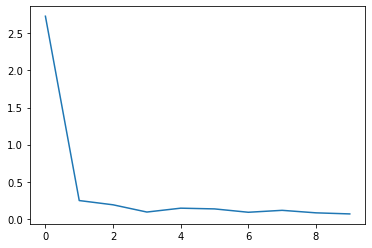

In [8]:
plt.plot(history.history['loss'])

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

history = model.fit(
    training_images,
    validation_data=test_images,
    validation_steps=30,
    epochs=EPOCHS,
    steps_per_epoch=30,
)

Epoch 1/10
30/30 [==============================] - 18s 609ms/step - loss: 0.9786 - categorical_accuracy: 0.7500 - val_loss: 11.6926 - val_categorical_accuracy: 0.2385
Epoch 2/10
30/30 [==============================] - 18s 584ms/step - loss: 0.8058 - categorical_accuracy: 0.7537 - val_loss: 736.2289 - val_categorical_accuracy: 0.1135
Epoch 3/10
30/30 [==============================] - 17s 576ms/step - loss: 0.6650 - categorical_accuracy: 0.8115 - val_loss: 81.3667 - val_categorical_accuracy: 0.3125
Epoch 4/10
30/30 [==============================] - 17s 583ms/step - loss: 0.7778 - categorical_accuracy: 0.7542 - val_loss: 30.2523 - val_categorical_accuracy: 0.2125
Epoch 5/10
30/30 [==============================] - 17s 578ms/step - loss: 0.5082 - categorical_accuracy: 0.8362 - val_loss: 11.2651 - val_categorical_accuracy: 0.1656
Epoch 6/10
30/30 [==============================] - ETA: 0s - loss: 0.6384 - categorical_accuracy: 0.8240

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
model.save('model.h5')

In [ ]:
img = tf.keras.preprocessing.image.load_img("natural_images/cat/cat_0000.jpg", target_size=IMAGE_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = tf.keras.applications.resnet_v2.preprocess_input(img_array)

plt.imshow(img)

In [ ]:
predictions = model.predict(img_array)
# scores = tf.nn.softmax(predictions[0])
scores = predictions[0]

print(predictions)
# print(tf.keras.applications.resnet_v2.decode_predictions(predictions))

classes_reversed = {v: k for k, v in training_images.class_indices.items()}
guesses = {}

for i, score in enumerate(scores):
    class_name = classes_reversed[i]
    guesses[class_name] = score

for fruit, score in {k: v for k, v in sorted(guesses.items(), key=lambda item: item[1], reverse=True)}.items():
    pass
    print("{}: {:.2f}%".format(fruit, score * 100))
